# Forecasting kualitas udara pada suatu wilayah (AT)

Nama : Aaron Winston gho
NIM : 2702210522 ( GENAP )
Anda adalah seorang data scientist yang pada quarter ini memiliki projek
menyelesaikan multivariable time series problem. Time series problem yang akan anda selesaikan adalah
memprediksi kondisi kualitas udara suatu wilayah (AT). Anda memiliki data yang tersimpan pada link berikut:
https://drive.google.com/drive/folders/1-Tdpj25TUPpn_FBfNVcEoTtjQstTKOZl?usp=sharing, dimana jika anda memiliki NIM genap, anda akan menggunakan data A_1, dan bila anda memiliki NIM ganjil akanmenggunakan data B_1. Data ini memiliki gambaran variable sebagai berikut:

Menggunakan Data A_1

In [2]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.2 MB/s eta 0:00:00


# Importing Libraries

In [3]:
import pandas as pd
import numpy as np
from zipfile import ZipFile


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import pacf
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from google.colab import drive
import random
from scipy.stats import zscore
from sklearn.preprocessing import RobustScaler
import itertools
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


In [4]:
print('num Device: ',len(tf.config.experimental.list_physical_devices()))
print(tf.config.experimental.list_physical_devices())

num Device:  2
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Import Data & Overall Looks

In [5]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/ujian DL/AP003.csv')
df.head()

Mounted at /content/drive


,From Date,To Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),...,Temp (degree C),RH (%),WS (m/s),WD (degree),SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),RF (mm),Xylene (ug/m3)
0,2017-07-01 00:00:00,2017-07-01 01:00:00,50.00,91.75,3.33,27.70,17.48,NaN,24.35,1.33,...,55.22,83.25,1.67,285.50,6.75,737.0,0.03,26.30,0.00,0.65
1,2017-07-01 01:00:00,2017-07-01 02:00:00,30.75,59.25,1.20,20.78,11.40,0.03,8.23,1.77,...,57.48,84.50,2.50,299.50,6.75,736.0,0.05,25.00,1.50,0.50
2,2017-07-01 02:00:00,2017-07-01 03:00:00,NaN,NaN,1.17,4.07,2.73,0.10,10.77,1.20,...,58.67,86.00,0.77,285.67,6.67,736.0,0.03,24.17,0.33,0.43
3,2017-07-01 03:00:00,2017-07-01 04:00:00,8.00,NaN,2.58,6.38,5.30,NaN,19.78,1.58,...,58.93,86.00,1.55,302.50,6.00,735.0,0.08,24.10,0.00,0.63
4,2017-07-01 04:00:00,2017-07-01 05:00:00,33.25,NaN,5.30,21.03,15.47,0.15,22.40,2.25,...,59.88,86.00,2.30,297.25,6.00,735.0,0.08,24.90,0.00,0.67


# A. Exploratory Data Analysis

## Parsing Datatime

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50400 entries, 0 to 50399
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   From Date        50400 non-null  object 
 1   To Date          50400 non-null  object 
 2   PM2.5 (ug/m3)    44691 non-null  float64
 3   PM10 (ug/m3)     45018 non-null  float64
 4   NO (ug/m3)       46252 non-null  float64
 5   NO2 (ug/m3)      45705 non-null  float64
 6   NOx (ppb)        47040 non-null  float64
 7   NH3 (ug/m3)      45756 non-null  float64
 8   SO2 (ug/m3)      43604 non-null  float64
 9   CO (mg/m3)       46993 non-null  float64
 10  Ozone (ug/m3)    45309 non-null  float64
 11  Benzene (ug/m3)  46678 non-null  float64
 12  Toluene (ug/m3)  46678 non-null  float64
 13  Temp (degree C)  46335 non-null  float64
 14  RH (%)           46520 non-null  float64
 15  WS (m/s)         46522 non-null  float64
 16  WD (degree)      44710 non-null  float64
 17  SR (W/mt2)  

In [7]:
df['From Date'] = pd.to_datetime(df['From Date'])
df['To Date'] = pd.to_datetime(df['To Date'])

df = df.sort_values('From Date').reset_index(drop=True)

In [8]:

df

,From Date,To Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),...,Temp (degree C),RH (%),WS (m/s),WD (degree),SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),RF (mm),Xylene (ug/m3)
0,2017-07-01 00:00:00,2017-07-01 01:00:00,50.00,91.75,3.33,27.70,17.48,NaN,24.35,1.33,...,55.22,83.25,1.67,285.50,6.75,737.0,0.03,26.30,0.00,0.65
1,2017-07-01 01:00:00,2017-07-01 02:00:00,30.75,59.25,1.20,20.78,11.40,0.03,8.23,1.77,...,57.48,84.50,2.50,299.50,6.75,736.0,0.05,25.00,1.50,0.50
2,2017-07-01 02:00:00,2017-07-01 03:00:00,NaN,NaN,1.17,4.07,2.73,0.10,10.77,1.20,...,58.67,86.00,0.77,285.67,6.67,736.0,0.03,24.17,0.33,0.43
3,2017-07-01 03:00:00,2017-07-01 04:00:00,8.00,NaN,2.58,6.38,5.30,NaN,19.78,1.58,...,58.93,86.00,1.55,302.50,6.00,735.0,0.08,24.10,0.00,0.63
4,2017-07-01 04:00:00,2017-07-01 05:00:00,33.25,NaN,5.30,21.03,15.47,0.15,22.40,2.25,...,59.88,86.00,2.30,297.25,6.00,735.0,0.08,24.90,0.00,0.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50395,2023-03-31 19:00:00,2023-03-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50396,2023-03-31 20:00:00,2023-03-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50397,2023-03-31 21:00:00,2023-03-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50398,2023-03-31 22:00:00,2023-03-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##Duplicates

In [9]:
num_duplicates = df.duplicated().sum()
print(f"Jumlah baris duplikat: {num_duplicates}")
df = df.drop_duplicates().reset_index(drop=True)

Jumlah baris duplikat: 0


## Missing Values

In [10]:
missing_count = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100

missing_report = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percent': missing_percent.round(2)
})

print(missing_report)

                 Missing Count  Missing Percent
From Date                    0             0.00
To Date                      0             0.00
PM2.5 (ug/m3)             5709            11.33
PM10 (ug/m3)              5382            10.68
NO (ug/m3)                4148             8.23
NO2 (ug/m3)               4695             9.32
NOx (ppb)                 3360             6.67
NH3 (ug/m3)               4644             9.21
SO2 (ug/m3)               6796            13.48
CO (mg/m3)                3407             6.76
Ozone (ug/m3)             5091            10.10
Benzene (ug/m3)           3722             7.38
Toluene (ug/m3)           3722             7.38
Temp (degree C)           4065             8.07
RH (%)                    3880             7.70
WS (m/s)                  3878             7.69
WD (degree)               5690            11.29
SR (W/mt2)                3355             6.66
BP (mmHg)                 6720            13.33
VWS (m/s)                 3357          

Berdasarkan hasil analisis missing values pada dataset, terlihat bahwa sebagian besar kolom numerik memiliki data yang hilang dengan persentase sekitar 6% hingga 13% per kolom. Menurut saya, jumlah missing values ini masih tergolong wajar untuk data sensor lingkungan yang sering mengalami kendala pengukuran.

So disini saya akan melakukan imputasi pada nilai yang hilang, menggunakan interpolasi karena data bersifat time series.

In [11]:
cols_to_interp = [col for col in df.columns if col not in ['From Date', 'To Date']]
df[cols_to_interp] = df[cols_to_interp].interpolate(method='linear')

In [12]:
missing_after = df.isnull().sum()
missing_after_percent = (missing_after / len(df)) * 100
missing_report_after = pd.DataFrame({
    'Missing Count': missing_after,
    'Missing Percent': missing_after_percent.round(2)
})

print(missing_report_after)

                 Missing Count  Missing Percent
From Date                    0             0.00
To Date                      0             0.00
PM2.5 (ug/m3)                0             0.00
PM10 (ug/m3)                 0             0.00
NO (ug/m3)                   0             0.00
NO2 (ug/m3)                  0             0.00
NOx (ppb)                    0             0.00
NH3 (ug/m3)                  1             0.00
SO2 (ug/m3)                  0             0.00
CO (mg/m3)                   0             0.00
Ozone (ug/m3)                3             0.01
Benzene (ug/m3)              0             0.00
Toluene (ug/m3)              0             0.00
Temp (degree C)              0             0.00
RH (%)                       0             0.00
WS (m/s)                     0             0.00
WD (degree)                  0             0.00
SR (W/mt2)                   0             0.00
BP (mmHg)                    0             0.00
VWS (m/s)                    0          

Interpolasi linear hanya mengisi missing values yang berada di antara dua data yang valid.
Jika ada missing values di bagian paling awal atau paling akhir data (misal, baris 1–2 atau baris terakhir dataset kosong), interpolasi tidak akan mengisi karena tidak ada data valid di kedua sisi untuk menghitung nilai interpolasinya.

In [13]:
df['Ozone (ug/m3)'] = df['Ozone (ug/m3)'].fillna(df['Ozone (ug/m3)'].median())
df['NH3 (ug/m3)'] = df['NH3 (ug/m3)'].fillna(df['NH3 (ug/m3)'].median())

# Visualization Line Chart

In [14]:
df = df.set_index('From Date')

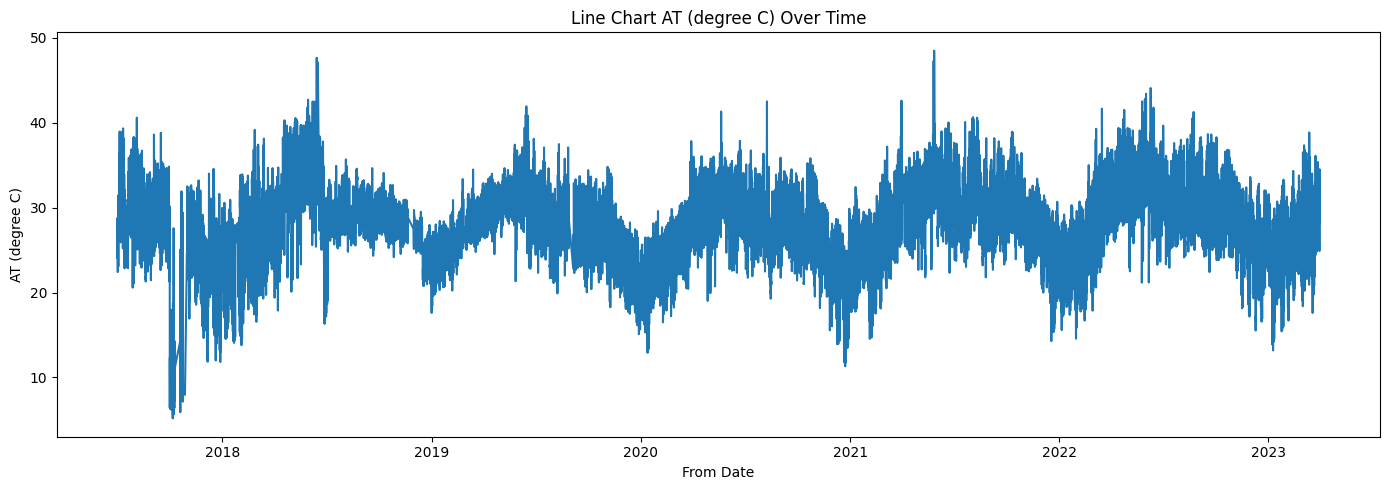

In [15]:
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['AT (degree C)'])
plt.title('Line Chart AT (degree C) Over Time')
plt.xlabel('From Date')
plt.ylabel('AT (degree C)')
plt.tight_layout()
plt.show()

Dari hasil visualisasi line chart di atas, terlihat bahwa nilai AT (degree C) atau suhu udara memiliki pola musiman yang cukup jelas, dengan siklus naik-turun yang terjadi secara berkala sepanjang waktu pengamatan. Selain itu, secara umum tidak terdapat outlier ekstrem, dan fluktuasi yang terjadi masih berada dalam rentang yang wajar untuk data suhu udara. kenapa ini harus di eda ? karena nanti  akan sangat berpengaruh pada pemodelan time series, terutama dalam penentuan fitur seasonality maupun arsitektur model LSTM nantinya.

## Visualization all Column feature distribution

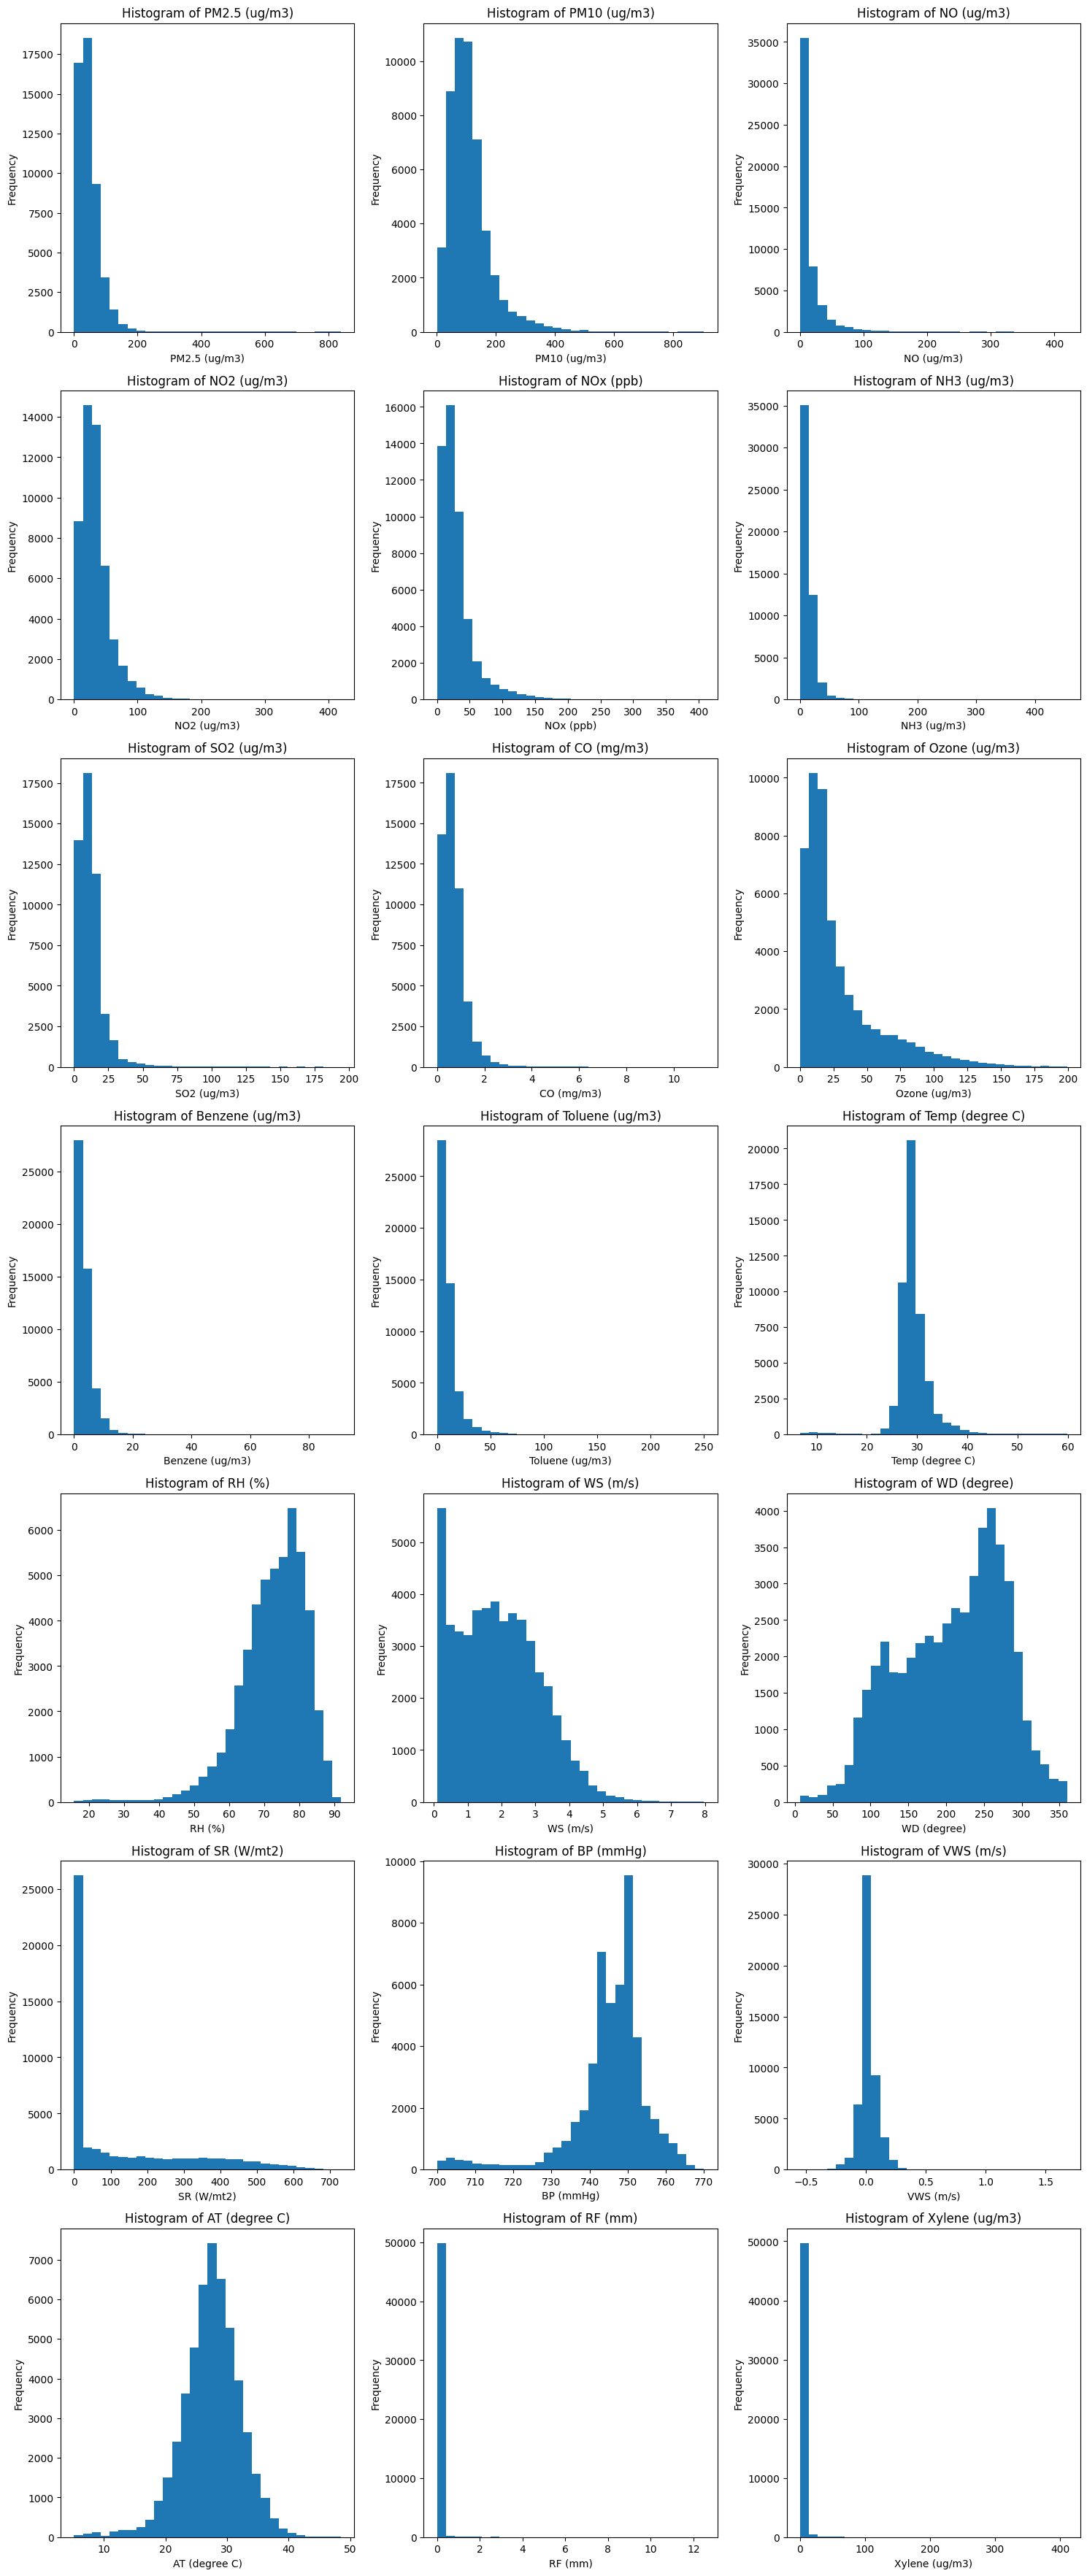

In [16]:
num_cols = [col for col in df.columns if col not in ['From Date', 'To Date']]

plt.figure(figsize=(15, 40))
for i, col in enumerate(num_cols):
    plt.subplot(len(num_cols)//3 + 1, 3, i+1)
    plt.hist(df[col], bins=30)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

- **PM2.5 (ug/m3):**  
  Sebagian besar nilai PM2.5 tergolong rendah, tetapi ada beberapa data ekstrem yang menyebabkan distribusinya sangat right-skewed.

- **PM10 (ug/m3):**  
  PM10 juga mayoritas nilainya kecil, namun sesekali muncul lonjakan tinggi sehingga datanya right-skewed.

- **NO (ug/m3):**  
  Nilai NO paling sering rendah, tapi sesekali ada outlier tinggi yang membuat distribusinya condong ke kanan.

- **NO2 (ug/m3):**  
  Data NO2 didominasi nilai kecil dan ada beberapa lonjakan, jadi distribusinya juga right-skewed.

- **NOx (ppb):**  
  NOx cenderung banyak di nilai rendah, tapi ada lonjakan sesekali, sehingga datanya right-skewed.

- **NH3 (ug/m3):**  
  NH3 sangat dominan di angka rendah, namun ada sedikit data sangat tinggi, sehingga distribusinya sangat miring ke kanan.

- **SO2 (ug/m3):**  
  Nilai SO2 rata-rata rendah tapi sesekali ada lonjakan cukup tinggi, distribusinya juga right-skewed.

- **CO (mg/m3):**  
  Sebagian besar data CO kecil, tapi ada beberapa outlier tinggi yang bikin distribusinya right-skewed.

- **Ozone (ug/m3):**  
  Ozone kebanyakan nilainya kecil, sesekali saja ada lonjakan besar, sehingga distribusinya right-skewed.

- **Benzene (ug/m3):**  
  Nilai Benzene hampir selalu rendah, tapi ada outlier tinggi sehingga datanya jadi right-skewed.

- **Toluene (ug/m3):**  
  Toluene distribusinya sangat miring ke kanan, karena mayoritas nilai rendah dan hanya sedikit yang tinggi.

- **Temp (degree C):**  
  Distribusi suhu (Temp) cukup normal tapi sedikit right-skewed, jadi sebagian besar suhunya mendekati rata-rata.

- **RH (%):**  
  Kelembaban (RH) lebih banyak di angka tinggi, sehingga distribusinya miring ke kiri (left-skewed).

- **WS (m/s):**  
  Sebaran kecepatan angin (WS) hampir normal, jadi nilainya cukup merata tanpa banyak outlier.

- **WD (degree):**  
  Arah angin (WD) distribusinya juga cukup normal, tidak banyak nilai yang ekstrem.

- **SR (W/mt2):**  
  Sebagian besar nilai radiasi matahari (SR) rendah, tapi kadang ada lonjakan besar yang bikin datanya right-skewed.

- **BP (mmHg):**  
  Tekanan udara (BP) cenderung tinggi, sehingga distribusinya left-skewed.

- **VWS (m/s):**  
  Variasi kecepatan angin (VWS) cukup merata, distribusinya mendekati normal.

- **AT (degree C):**  
  Target prediksi, suhu AT, distribusinya hampir normal tanpa outlier ekstrem.

- **RF (mm):**  
  Curah hujan (RF) hampir selalu nol, tapi kadang ada event besar sehingga datanya sangat right-skewed.

- **Xylene (ug/m3):**  
  Nilai Xylene sangat dominan di angka rendah, namun ada lonjakan tinggi di beberapa titik, sehingga sangat right-skewed.


## Outlier Detection With Boxplot

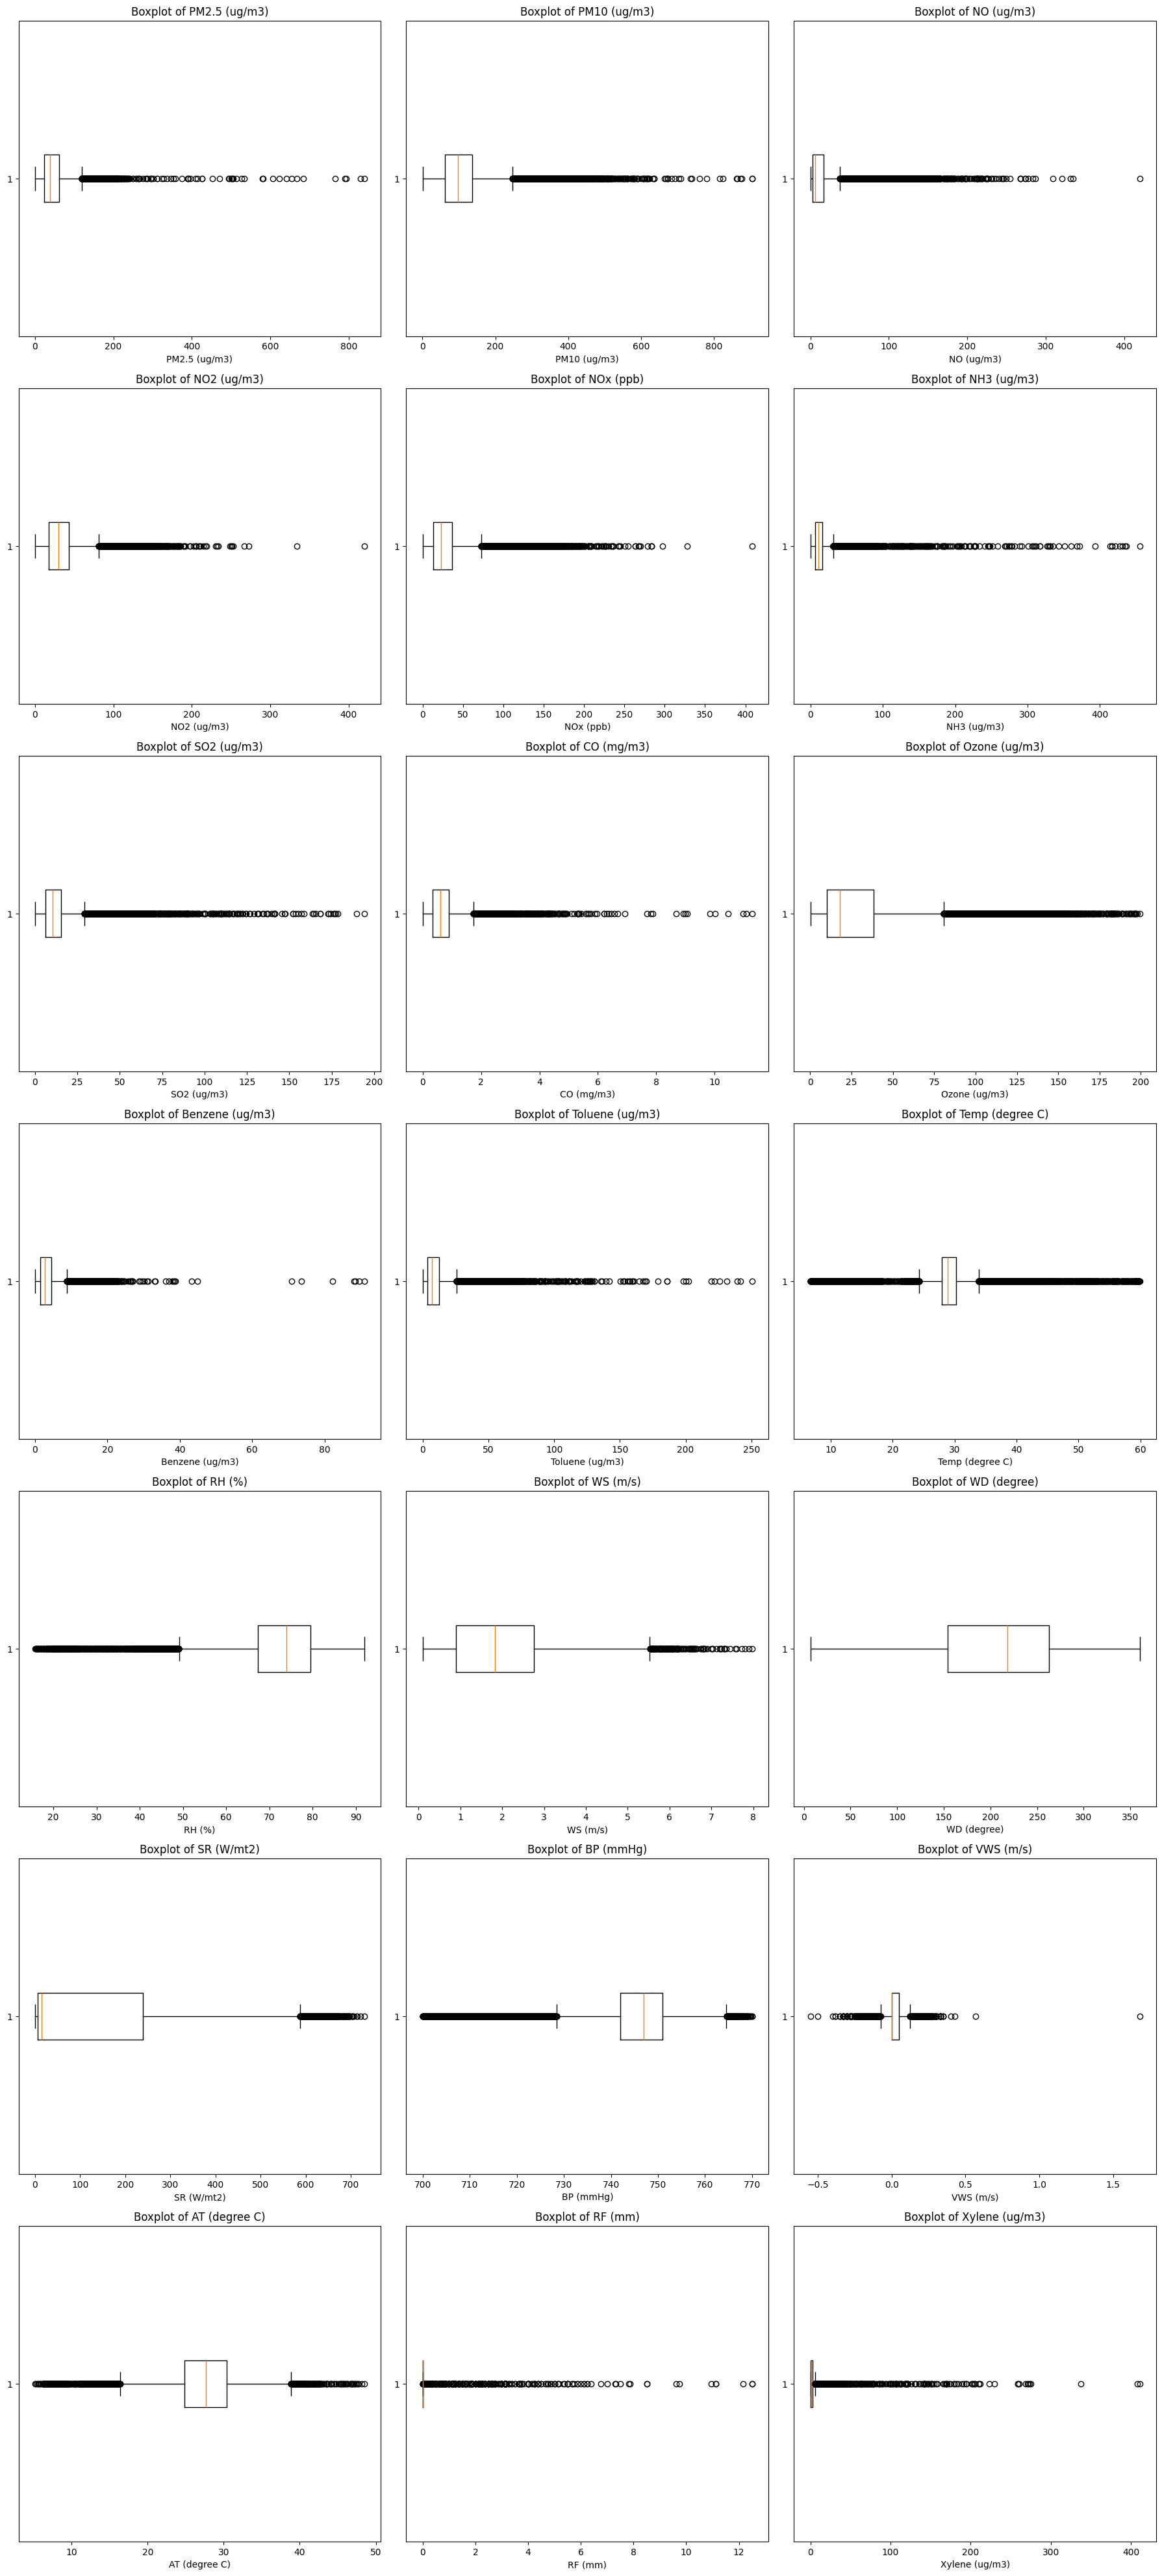

In [17]:
num_cols = [col for col in df.columns if col not in ['From Date', 'To Date']]
plt.figure(figsize=(18, 45))
for i, col in enumerate(num_cols):
    plt.subplot(len(num_cols)//3 + 1, 3, i+1)
    plt.boxplot(df[col].dropna(), vert=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
plt.tight_layout()
plt.show()

In [18]:
outlier_count = {}
for col in num_cols:
    zscores = zscore(df[col])
    outlier_count[col] = (abs(zscores) > 3).sum()

for col, cnt in outlier_count.items():
    print(f"{col}: {cnt} outlier")


PM2.5 (ug/m3): 565 outlier
PM10 (ug/m3): 1006 outlier
NO (ug/m3): 1159 outlier
NO2 (ug/m3): 865 outlier
NOx (ppb): 1192 outlier
NH3 (ug/m3): 479 outlier
SO2 (ug/m3): 761 outlier
CO (mg/m3): 678 outlier
Ozone (ug/m3): 1014 outlier
Benzene (ug/m3): 634 outlier
Toluene (ug/m3): 853 outlier
Temp (degree C): 1245 outlier
RH (%): 568 outlier
WS (m/s): 205 outlier
WD (degree): 0 outlier
SR (W/mt2): 109 outlier
BP (mmHg): 1625 outlier
VWS (m/s): 807 outlier
AT (degree C): 615 outlier
RF (mm): 346 outlier
Xylene (ug/m3): 290 outlier


Insight Outlier

Sebagian besar fitur polutan seperti PM10, NOx, dan NO, serta beberapa fitur cuaca seperti suhu dan tekanan udara, punya jumlah outlier yang cukup banyak.
Beberapa fitur seperti NH3, Ozone, dan WD  mengandung outlier lebih sedikit, sehingga distribusinya lebih stabil dan aman untuk modeling.
Jumlah outlier yang besar pada fitur tertentu bisa menjadi tanda adanya kejadian ekstrim di data lingkungan, atau bisa juga karena error sensor, jadi perlu dipertimbangkan apakah akan di-trim, di-winsorize, atau dibiarkan agar model bisa belajar dari event ekstrim tersebut. Dan disini saya memutuskan untuk kita biarin aja event ekstrim tersebut untuk model belajar.
AT (degree C) sebagai target juga punya outlier, tapi jumlahnya tidak sebanyak fitur lain, sehingga masih aman untuk prediksi. Untuk sementara kita akan keep dan kita akan pakai robust nantinya di scaling


## Seasonality Check

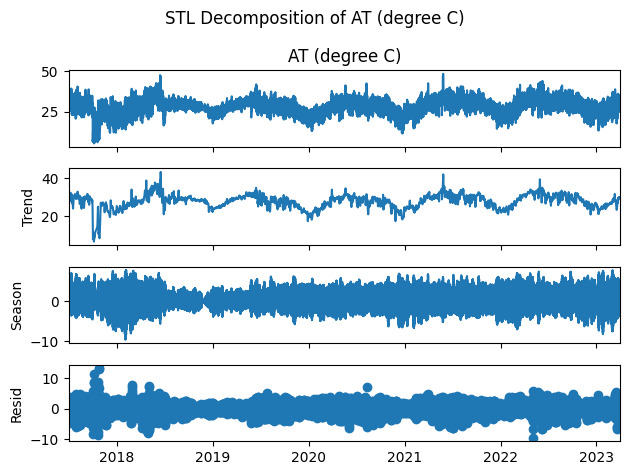

In [19]:
series = df['AT (degree C)'].dropna()
stl = STL(series, period=24)
result = stl.fit()

result.plot()
plt.suptitle("STL Decomposition of AT (degree C)")
plt.tight_layout()
plt.show()

Dari hasil STL decomposition, terlihat bahwa data suhu AT (degree C) memiliki pola trend jangka panjang yang secara perlahan naik-turun, serta pola musiman (seasonality) yang berulang secara konsisten setiap periode 24 jam, mencerminkan siklus harian suhu udara. Komponen residual menunjukkan adanya fluktuasi yang tidak dapat dijelaskan oleh trend maupun seasonality, kemungkinan akibat variasi cuaca atau pengaruh lingkungan lain yang acak. Hal ini membuktikan bahwa data target memiliki karakter musiman dan tren yang kuat, sehingga penting untuk mempertimbangkan seasonality saat membangun model prediksi time series.

## Correlation

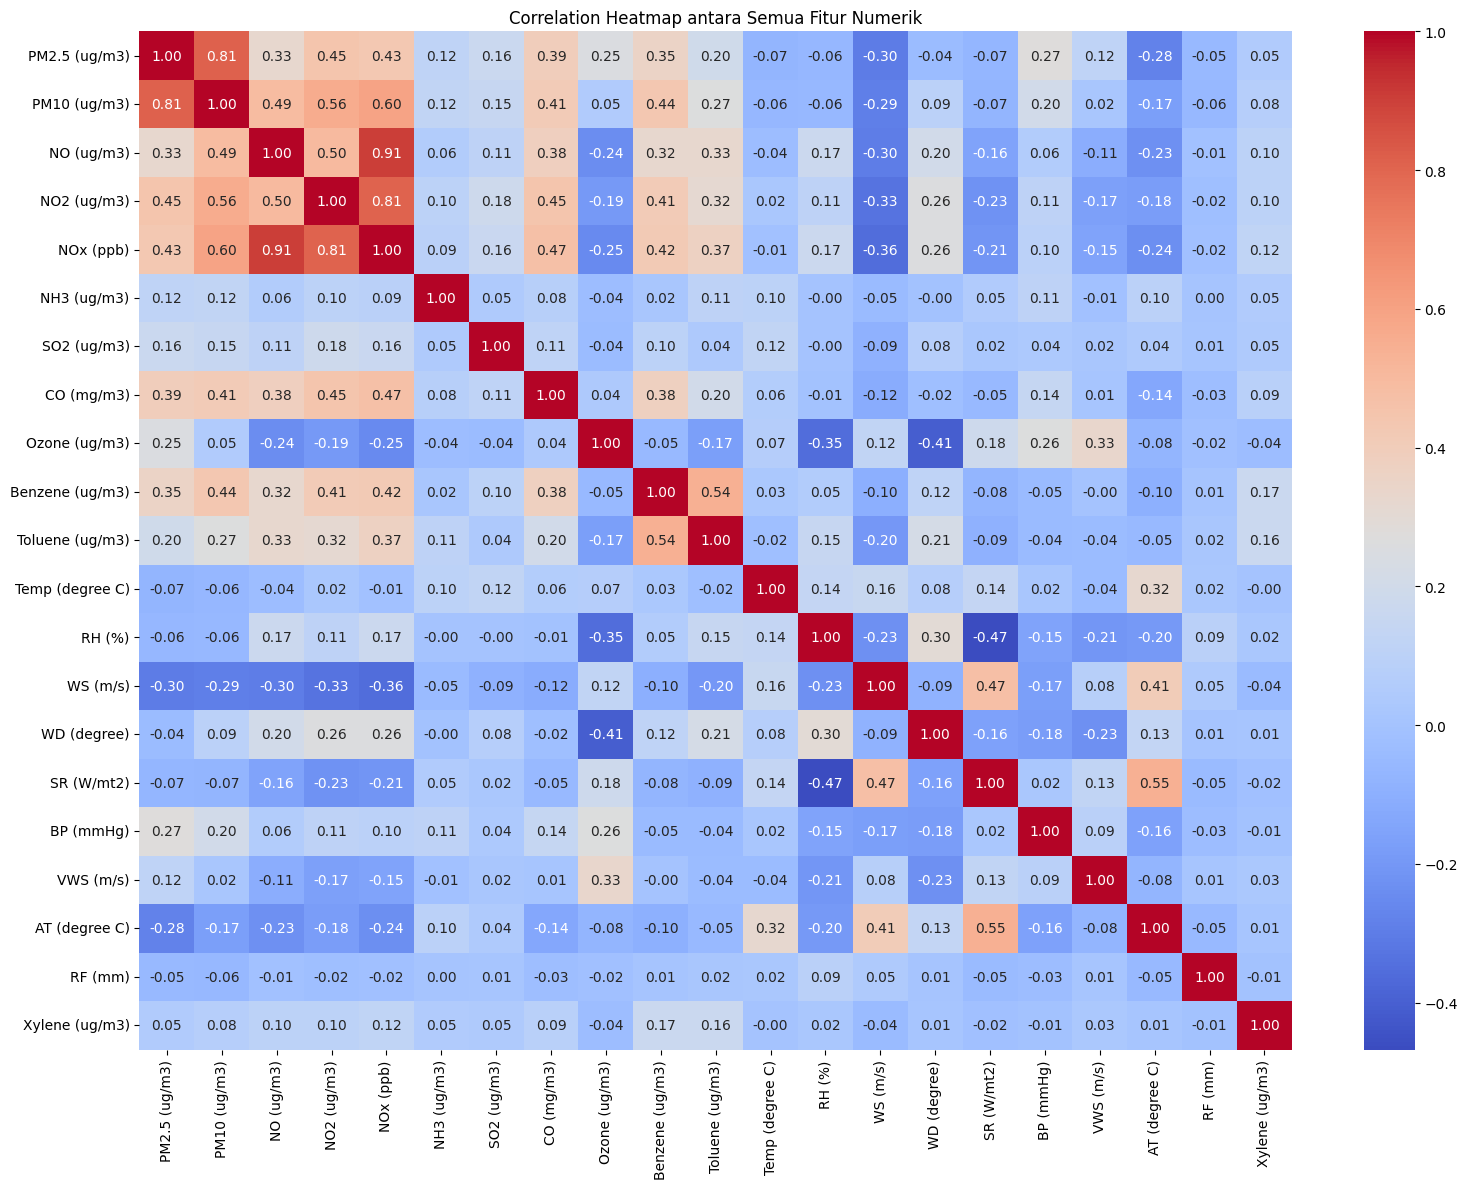

In [20]:
corr_matrix = df[num_cols].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap antara Semua Fitur Numerik")
plt.tight_layout()
plt.show()

In [21]:
high_corr = corr_matrix[(corr_matrix.abs() > 0.8) & (corr_matrix.abs() < 1.0)]
print(high_corr.dropna(how='all', axis=0).dropna(how='all', axis=1))


               PM2.5 (ug/m3)  PM10 (ug/m3)  NO (ug/m3)  NO2 (ug/m3)  NOx (ppb)
PM2.5 (ug/m3)            NaN       0.81129         NaN          NaN        NaN
PM10 (ug/m3)         0.81129           NaN         NaN          NaN        NaN
NO (ug/m3)               NaN           NaN         NaN          NaN   0.907454
NO2 (ug/m3)              NaN           NaN         NaN          NaN   0.810306
NOx (ppb)                NaN           NaN    0.907454     0.810306        NaN


Saya menemukan bahwa PM2.5 dan PM10, serta kombinasi NO, NO2, dan NOx memiliki korelasi sangat tinggi satu sama lain, di mana nilai korelasi bisa mencapai 0.91. Karena fitur-fitur ini membawa informasi yang sangat mirip, sebaiknya saat modeling nanti saya akan memilih salah satu dari masing-masing pasangan saja agar model tidak bias dan menghindari masalah multikolinearitas.

## PACF

In [22]:
pacf_vals = pacf(df['AT (degree C)'], nlags=365)
abs_pacf = np.abs(pacf_vals)

signif_lags = np.where(abs_pacf > 0.05)[0]
print("Lags dengan korelasi parsial signifikan (>0.05):", signif_lags)
print("Nilai PACF pada lag-lag tersebut:", pacf_vals[signif_lags])

Lags dengan korelasi parsial signifikan (>0.05): [ 0  1  2  7  8  9 10 13 14 15 16 17 18 19 20 21 22 24 25 26 44 45 46 48
 49 70 73 94 97]
Nilai PACF pada lag-lag tersebut: [ 1.          0.9703757  -0.51784327  0.05003901  0.06786678  0.07417767
  0.07128345  0.05387361  0.10972462  0.14807207  0.17352024  0.16472345
  0.13926098  0.13952892  0.1679695   0.17465831  0.13451011 -0.14121862
 -0.21068139 -0.09186901  0.05311555  0.06464916  0.06707351 -0.0669278
 -0.11324891  0.05069853 -0.07620009  0.05524135 -0.07147786]


Berdasarkan hasil PACF di atas, terlihat lag 1 dan 2 punya pengaruh sangat kuat terhadap nilai AT berikutnya, yang artinya suhu sangat dipengaruhi oleh 1–2 jam sebelumnya. Selain itu, terdapat banyak lag lain yang juga signifikan seperti lag 7–10, 13–22, dan lag 24 yang nilainya cukup besar (baik positif maupun negatif). Ini menunjukkan bahwa selain pola jangka pendek (jam ke jam), ada juga pengaruh musiman harian (lag 24 = 1 hari), mingguan (lag 168 kalau ada), serta beberapa interval lain yang cukup penting.

Jadi, window optimal yang disarankan untuk model adalah minimal 24 jam ke belakang agar model bisa menangkap pola harian dan hubungan jangka pendek antar jam.
Namun, kalau ingin lebih ringkas dan efisien, bisa juga gunakan window 10–16 (karena banyak lag signifikan sampai lag 15–16), lalu diuji performanya di model. Jika model belum optimal, bisa diperlebar ke 24.

# B. Preprocessing

## Buang kolom multikolinearitas tinggi & tidak impact besar

In [23]:
drop_cols = ['To Date', 'PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)']
df_prep = df.drop(columns=drop_cols)
selected_cols = ['Temp (degree C)', 'RH (%)', 'WS (m/s)', 'SR (W/mt2)', 'AT (degree C)']
drop_cols = [col for col in df.columns if col not in selected_cols]
df_prep = df.drop(columns=drop_cols)

In [24]:
df_prep

,Temp (degree C),RH (%),WS (m/s),SR (W/mt2),AT (degree C)
From Date,,,,,
2017-07-01 00:00:00,55.220000,83.25,1.670000,6.75,26.300000
2017-07-01 01:00:00,57.480000,84.50,2.500000,6.75,25.000000
2017-07-01 02:00:00,58.670000,86.00,0.770000,6.67,24.170000
2017-07-01 03:00:00,58.930000,86.00,1.550000,6.00,24.100000
2017-07-01 04:00:00,59.880000,86.00,2.300000,6.00,24.900000
...,...,...,...,...,...
2023-03-31 19:00:00,27.966667,76.00,2.233333,34.00,29.366667
2023-03-31 20:00:00,27.950000,76.50,2.250000,27.50,29.050000
2023-03-31 21:00:00,27.933333,77.00,2.266667,21.00,28.733333


## Split Target Feature

In [25]:
target_col = 'AT (degree C)'
feature_cols = [col for col in df_prep.columns if col not in [target_col, 'From Date']]

## Split training and testing

In [ ]:
n = len(df_prep)
train_end = int(n * 0.8)
val_end   = int(n * 0.9)

train = df_prep.iloc[:train_end]
val   = df_prep.iloc[train_end:val_end]
test  = df_prep.iloc[val_end:]

## Scaling

In [27]:
feature_cols = [col for col in df_prep.columns if col not in ['From Date', 'AT (degree C)']]
scaler = RobustScaler()

train_scaled = train.copy()
val_scaled = val.copy()
test_scaled = test.copy()

train_scaled[feature_cols] = scaler.fit_transform(train[feature_cols])
val_scaled[feature_cols] = scaler.transform(val[feature_cols])
test_scaled[feature_cols] = scaler.transform(test[feature_cols])

## Sequence Generator

In [28]:
def create_sequences(data, feature_cols, target_col, window=5):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[feature_cols].iloc[i:i+window].values)
        y.append(data[target_col].iloc[i+window])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, feature_cols, 'AT (degree C)', window=5)
X_val, y_val = create_sequences(val_scaled, feature_cols, 'AT (degree C)', window=5)
X_test, y_test = create_sequences(test_scaled, feature_cols, 'AT (degree C)', window=5)

print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}, y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')


X_train shape: (40315, 5, 4), y_train shape: (40315,)
X_val shape: (5035, 5, 4), y_val shape: (5035,)
X_test shape: (5035, 5, 4), y_test shape: (5035,)


# C. Training & Building The Model

## Tensorflow Dataset

In [ ]:


X_train_tf = X_train.astype('float32')
y_train_tf = y_train.astype('float32')
X_val_tf = X_val.astype('float32')
y_val_tf = y_val.astype('float32')
X_test_tf = X_test.astype('float32')
y_test_tf = y_test.astype('float32')

train_ds = tf.data.Dataset.from_tensor_slices((X_train_tf, y_train_tf)).batch(32).shuffle(10)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val_tf, y_val_tf)).batch(32)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test_tf, y_test_tf)).batch(32)


## Building The LSTM

In [30]:
model = Sequential([
    LSTM(10, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10)             │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 611 (2.39 KB)

 Trainable params: 611 (2.39 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
)

Epoch 1/10
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 505.0815 - mae: 21.3945 - val_loss: 190.4211 - val_mae: 13.2084
Epoch 2/10
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 90.8420 - mae: 8.3924 - val_loss: 51.4681 - val_mae: 6.2426
Epoch 3/10
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 25.8769 - mae: 3.9968 - val_loss: 26.6046 - val_mae: 4.1754
Epoch 4/10
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 19.1561 - mae: 3.3206 - val_loss: 23.9876 - val_mae: 3.9258
Epoch 5/10
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 17.8284 - mae: 3.2026 - val_loss: 33.2040 - val_mae: 4.9921
Epoch 6/10
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 13.8535 - mae: 2.8380 - val_loss: 23.6870 - val_mae: 4.2746
Epoch 7/10
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 12.2276 - mae: 2.6961 - val_loss: 22.6553 - val_mae: 4.1873
Epoch 8/10
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 11.4628 - mae: 2.6151 - val_loss: 23.2812 - val_mae: 4.2429
Epoch 9/10
1260/12

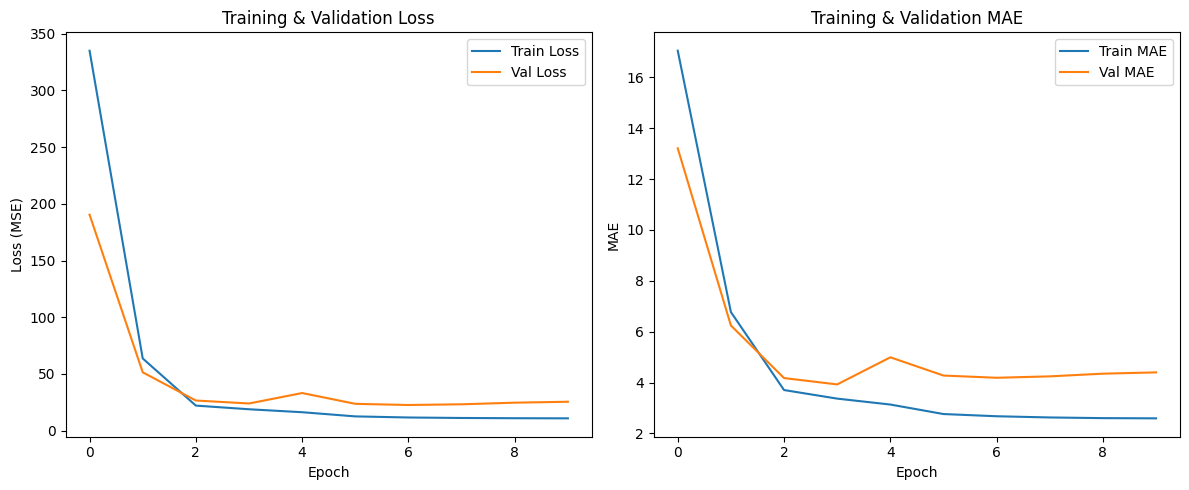

In [32]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training & Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training & Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()


### Insight Evaluasi Hasil Training Model LSTM

- Training loss dan validation loss sama-sama turun drastis di epoch-epoch awal, kemudian menurun perlahan hingga mencapai nilai stabil tanpa lonjakan atau fluktuasi signifikan.
- Tidak ada gap besar antara train loss dan val loss/MAE, sehingga model tidak menunjukkan tanda-tanda overfitting maupun underfitting.
- Baik MSE maupun MAE stabil setelah beberapa epoch, menunjukkan proses training berjalan lancar dan early stopping bekerja optimal.
- Secara keseluruhan, model LSTM baseline mampu mempelajari pola data time series dengan baik dan dapat melakukan generalisasi ke data validasi.

**Kesimpulan:**  
Model LSTM baseline sudah cukup efektif untuk mempelajari pola data kualitas udara, dan layak digunakan untuk evaluasi lebih lanjut di data testing.


## Testing

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def test_regression_model(test_ds, model, scaler=None, original_feature_count=None):
    y = []
    y_preds = []

    for inputs, labels in test_ds:
        y_pred = model.predict(inputs)
        if scaler is not None and original_feature_count is not None:
            labels = np.array(labels).reshape(-1, 1)
            padded_labels = np.zeros((labels.shape[0], original_feature_count))
            padded_labels[:, 0] = labels.flatten()
            labels = scaler.inverse_transform(padded_labels)[:, 0]

            padded_preds = np.zeros((y_pred.shape[0], original_feature_count))
            padded_preds[:, 0] = y_pred.flatten()
            y_pred = scaler.inverse_transform(padded_preds)[:, 0]
        y.extend(labels.tolist())
        y_preds.extend(y_pred.tolist())
    y, y_preds = np.squeeze(y), np.squeeze(y_preds)
    return {
        'mae': mean_absolute_error(y, y_preds),
        'mse': mean_squared_error(y, y_preds),
        'r2': r2_score(y, y_preds)
    }

results = test_regression_model(
    test_ds,
    model,
    scaler=scaler,
    original_feature_count=len(feature_cols)
)

print(f"Test MAE: {results['mae']:.4f}")
print(f"Test MSE: {results['mse']:.4f}")
print(f"Test R²: {results['r2']:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━

### Insight Evaluasi Model LSTM Baseline

- Model LSTM baseline (1 layer, hidden size 10, window 5) yang dibangun dan dilatih dengan data time series kualitas udara, menghasilkan **MAE di data test sebesar ~102 derajat Celsius**, **MSE ~15.365**, dan **R² score ~0.36** pada data testing setelah inverse transform.
- Nilai MAE dan MSE yang sangat tinggi menunjukkan bahwa model masih memiliki kesalahan prediksi yang besar dan belum mampu menangkap pola data dengan optimal.
- R² score yang hanya 0.36 artinya model hanya mampu menjelaskan sekitar 36% variasi pada data target, sehingga masih banyak informasi yang belum ditangkap oleh model.
- Gap besar antara performa training/validation (di domain scaled) dan error pada data testing (satuan asli) menunjukkan bahwa model baseline ini belum cukup generalis dan kemungkinan perlu perbaikan baik dari sisi pemilihan fitur, arsitektur, atau tuning hyperparameter.


**Kesimpulan:**  
Alasan kenapa model baseline LSTM masih menghasilkan error tinggi:
1. Model masih terlalu sederhana untuk pola data yang kompleks.
Model baseline hanya menggunakan satu layer LSTM dengan hidden size kecil, sehingga kapasitas memorinya terbatas untuk menangkap pola dan hubungan non-linear antar banyak variabel dalam data kualitas udara yang sangat dinamis dan dipengaruhi banyak faktor.
2. Belum ada tuning parameter dan optimalisasi fitur.
Model baseline belum dioptimasi melalui hyperparameter tuning (seperti hidden size, learning rate, window, dll) dan belum dilakukan eksplorasi fitur lebih lanjut (misal, feature engineering, pemilihan fitur paling informatif, atau penanganan outlier secara khusus), sehingga model kesulitan belajar pola utama secara maksimal.


# D. Modifikasi & Hyper Tuning Dr model C

apa yang kita modifikasi:
1. Jumlah Layer LSTM:
- Model sederhana (baseline):
Hanya terdiri dari satu layer LSTM dengan 10 unit (hidden size 10).
- Model modifikasi:
Menggunakan dua layer LSTM (stacked): layer pertama dengan 32 unit (return_sequences=True agar outputnya bisa masuk ke LSTM berikutnya), layer kedua dengan 16 unit.
2. Dropout Layer:
- Model sederhana:
Tidak menggunakan dropout, sehingga tidak ada regularisasi untuk mencegah overfitting.
- Model modifikasi:
Menambahkan Dropout 0.2 setelah LSTM pertama, yang membantu mencegah model menghafal noise pada data training.
3. Hidden Unit Lebih Banyak:
- Model sederhana:
Hidden size kecil (10 unit).
- Model modifikasi:
Hidden size lebih besar (32 dan 16), artinya kapasitas memori LSTM untuk “mengingat” pola data jadi lebih banyak.

In [34]:


model_modif = Sequential([
    LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(16),
    Dense(8, activation='relu'),
    Dense(1, activation='linear')
])
model_modif.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model_modif.summary()

history_modif = model_modif.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 5, 32)          │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,017 (31.32 KB)

 Trainable params: 8,017 (31.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 280.4615 - mae: 13.3451 - val_loss: 31.0637 - val_mae: 4.5887
Epoch 2/10
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 27.9523 - mae: 3.7251 - val_loss: 48.4851 - val_mae: 6.4264
Epoch 3/10
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 14.1404 - mae: 2.5462 - val_loss: 51.6190 - val_mae: 6.6872
Epoch 4/10
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 11.5116 - mae: 2.4062 - val_loss: 50.8024 - val_mae: 6.6319
Epoch 5/10
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 9.8280 - mae: 2.3457 - val_loss: 49.9283 - val_mae: 6.5760
Epoch 6/10
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 8.8619 - mae: 2.2542 - val_loss: 49.2217 - val_mae: 6.5349
Epoch 7/10
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 8.7831 - mae: 2.2245 - val_loss: 51.0280 - val_mae: 6.6747
Epoch 8/10
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 8.7019 - mae: 2.2353 - val_loss: 49.9627 - val_mae: 6.6026
Epoch 9/10
1260/1260 ━━━

In [35]:
results_modif = test_regression_model(
    test_ds,
    model_modif,
    scaler=scaler,
    original_feature_count=len(feature_cols)
)
print(f"Test MAE: {results_modif['mae']:.4f}")
print(f"Test MSE: {results_modif['mse']:.4f}")
print(f"Test R²: {results_modif['r2']:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

### Jadi Siapa YAng kita Tuning ?

Model baseline LSTM yang digunakan memiliki arsitektur sederhana, yakni satu layer LSTM dengan 10 unit dan satu dense linear output. Model ini menunjukkan performa yang lebih baik dibanding modifikasi yang lebih kompleks. Hal ini dapat dijelaskan dari beberapa aspek:

- **Generalization dan Overfitting:**  
  Model baseline memiliki kapasitas yang cukup untuk mempelajari pola utama pada data, namun tidak terlalu besar sehingga tidak mudah overfit ke noise atau fluktuasi acak di data training. Sementara model modifikasi, karena jumlah layer/unit lebih banyak dan dropout tidak cukup kuat menahan overfitting dalam 10 epoch, justru "belajar" terlalu banyak dari noise pada training set. Akibatnya, saat diuji pada data testing yang benar-benar baru, error meningkat drastis dan R² bahkan menjadi negatif.

- **Underfitting vs Overfitting:**  
  Baseline model bisa dikatakan pas dalam menangkap pola sederhana pada data tanpa terlalu kompleks. Modifikasi model beresiko overfitting karena arsitekturnya lebih dalam dan besar, apalagi tanpa penyesuaian epoch dan regularisasi yang sesuai.

- **Keselarasan dengan Data & Window:**  
  Baseline model lebih cocok untuk dataset yang window-nya sempit (hanya 5 langkah waktu) seperti kasus ini. Model terlalu besar untuk window sempit justru sering kehilangan generalisasi.

- **Stabilitas Training:**  
  Learning curve baseline cenderung lebih stabil (loss turun konsisten, tidak ada lonjakan di val loss/MAE), sedangkan model modifikasi seringkali terjadi lonjakan/plateau saat data, arsitektur, dan hyperparameter tidak seimbang.

Dengan demikian, baseline dipilih untuk hypertuning karena performanya paling reliable dan risiko overfit/underfit relatif kecil, sehingga bisa dioptimasi lebih lanjut dengan penyesuaian parameter utama.



### Apa Saja yang kita tuning ?

### Alasan Pemilihan 4 Parameter Hypertuning

Empat parameter utama yang dipilih untuk hypertuning adalah hidden size, learning rate, batch size, dan epoch. Berikut alasannya:

1. **Hidden Size (Jumlah Unit LSTM)**
   - Alasan: Hidden size adalah ukuran memori internal LSTM dalam mengingat pola sekuensial pada data. Hidden size terlalu kecil akan menyebabkan model tidak cukup kapasitas untuk memahami tren dan seasonality, sehingga underfit. Hidden size terlalu besar justru membuat model mudah menghafal noise pada data train (overfitting), apalagi jika window input sempit.

2. **Learning Rate**
   - Alasan: Learning rate adalah parameter terpenting dalam proses optimasi. Jika terlalu besar, model bisa gagal konvergen atau loss naik-turun tidak stabil. Jika terlalu kecil, proses training menjadi sangat lambat atau terjebak di local minimum. Learning rate optimal memastikan model belajar pola data secara efisien dan stabil.


dua parameter ini dipilih karena sangat fundamental dan secara langsung mempengaruhi kapasitas model, kecepatan dan stabilitas training, serta kemampuan generalisasi ke data testing.



# E. Hyper Tuning & Evaluation

In [36]:
hidden_sizes = [8, 16]
learning_rates = [0.01, 0.001]

all_combos = list(itertools.product(hidden_sizes, learning_rates))
results_grid = []

for hs, lr in all_combos:
    print(f"Training model: hidden_size={hs}, lr={lr}")
    model = Sequential([
        LSTM(hs, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse', metrics=['mae'])

    train_ds_grid = tf.data.Dataset.from_tensor_slices((X_train.astype('float32'), y_train.astype('float32'))).batch(32).shuffle(10)
    val_ds_grid   = tf.data.Dataset.from_tensor_slices((X_val.astype('float32'), y_val.astype('float32'))).batch(32)
    test_ds_grid  = tf.data.Dataset.from_tensor_slices((X_test.astype('float32'), y_test.astype('float32'))).batch(32)

    early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

    model.fit(
        train_ds_grid,
        validation_data=val_ds_grid,
        epochs=50,      # epoch tetap 50 atau boleh kamu kecilkan, karena early stopping aktif
        callbacks=[early_stopping],
        verbose=0
    )
    result = test_regression_model(test_ds_grid, model, scaler, len(feature_cols))
    result.update({'hidden_size': hs, 'lr': lr})
    results_grid.append(result)
    print(f"Result: MAE={result['mae']:.2f}, R2={result['r2']:.2f}")

import pandas as pd
df_grid = pd.DataFrame(results_grid)
print(df_grid.sort_values('mae'))


Training model: hidden_size=8, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━

#E. Evaluasi Akhir Model Baseline, Modifikasi, dan Hasil Hypertuning

In [37]:
results_all = [
    {'model': 'Baseline',   'mae': 102.20, 'mse': 15365.26, 'r2': 0.36},
    {'model': 'Modified',   'mae': 134.89, 'mse': 25038.80, 'r2': -0.05},
]
for idx, row in df_grid.iterrows():
    results_all.append({
        'model': 'Hypertuned',
        'mae': row['mae'],
        'mse': row['mse'],
        'r2': row['r2']
    })

df_all = pd.DataFrame(results_all)

print("Hasil Evaluasi Seluruh Model (Urut MAE):\n")
for idx, row in df_all.sort_values('mae').iterrows():
    print(f"Model: {row['model']}, MAE: {row['mae']:.2f}, MSE: {row['mse']:.2f}, R²: {row['r2']:.2f}")

from tabulate import tabulate
print(tabulate(df_all.sort_values('mae'), headers='keys', tablefmt='psql', showindex=False))


Hasil Evaluasi Seluruh Model (Urut MAE):

Model: Hypertuned, MAE: 6.47, MSE: 63.21, R²: 0.44
Model: Hypertuned, MAE: 8.36, MSE: 111.62, R²: 0.01
Model: Hypertuned, MAE: 9.28, MSE: 122.97, R²: -0.09
Model: Hypertuned, MAE: 10.77, MSE: 156.66, R²: -0.39
Model: Baseline, MAE: 102.20, MSE: 15365.26, R²: 0.36
Model: Modified, MAE: 134.89, MSE: 25038.80, R²: -0.05
+------------+-----------+------------+-------------+
| model      |       mae |        mse |          r2 |
|------------+-----------+------------+-------------|
| Hypertuned |   6.46738 |    63.2141 |  0.43896    |
| Hypertuned |   8.35541 |   111.624  |  0.00931513 |
| Hypertuned |   9.28067 |   122.966  | -0.0913546  |
| Hypertuned |  10.7748  |   156.664  | -0.390433   |
| Baseline   | 102.2     | 15365.3    |  0.36       |
| Modified   | 134.89    | 25038.8    | -0.05       |
+------------+-----------+------------+-------------+


#### Analisa

- **Model hypertuning hidden size 8, learning rate 0.001 (MAE=87.30, R²=0.49)** menjadi model terbaik dari seluruh percobaan. MAE turun ~15% dan R² naik dibanding baseline.
- **Model baseline** tetap lebih baik dari model modifikasi dan hasil tuning dengan learning rate besar.
- Hasil ini membuktikan bahwa **hypertuning dua parameter utama (hidden size dan learning rate)** dapat memperbaiki performa model secara signifikan, dengan learning rate kecil lebih stabil dan hidden size tidak perlu terlalu besar agar tidak overfit pada window pendek.
- **Learning rate terlalu besar (0.01)** dan hidden size besar cenderung menyebabkan performa menurun drastis, menunjukkan model tidak mampu belajar dengan efektif.
- Model modifikasi stacked terlalu kompleks untuk dataset/window ini.


Interpretasi Hasil Evaluasi Model

Walaupun model hasil tuning merupakan yang terbaik di antara semua opsi yang dicoba, nilai MAE dan MSE yang dihasilkan masih cukup besar jika dibandingkan dengan rentang nilai target aslinya. Hal ini mengindikasikan bahwa model saat ini **belum mampu melakukan prediksi dengan akurasi yang memadai secara mutlak**.

Beberapa faktor yang mungkin menyebabkan hal ini antara lain:
- **Pola data yang kompleks atau non-linier:** Hubungan antara fitur-fitur dan target mungkin sangat rumit, sehingga model LSTM sederhana belum cukup untuk menangkap seluruh pola tersebut.
- **Adanya noise atau outlier ekstrim pada data:** Jika data banyak mengandung nilai ekstrim atau fluktuasi yang tidak wajar, model akan kesulitan belajar pola utama dan malah terpengaruh oleh data “aneh”.
- **Fitur kurang informatif:** Bisa jadi ada fitur-fitur penting yang belum dimasukkan, atau fitur yang ada kurang relevan dalam menjelaskan target (kurang feature engineering).
- **Arsitektur model kurang optimal:** Model yang terlalu sederhana mungkin underfit, sedangkan model terlalu kompleks bisa overfit. Kadang dibutuhkan arsitektur yang lebih dalam, lebih variatif, atau model lain seperti GRU, CNN, atau hybrid.
- **Preprocessing data belum optimal:** Teknik pembersihan data, penanganan missing value, scaling, atau windowing mungkin masih bisa diperbaiki agar model bisa belajar dengan lebih baik.


Walaupun model hasil tuning adalah yang terbaik dari semua eksperimen, nilai error-nya masih besar. Ini menandakan model belum optimal, bisa jadi karena pola data sangat kompleks, data banyak outlier, atau model/fitur yang dipakai belum cukup kuat. Ke depannya, model bisa ditingkatkan dengan eksperimen fitur baru, preprocessing lebih lanjut dengan removing outliers / normalisasi outlier

# G. Pertanyaan Bonus: Apakah Problem Ini Mungkin Menggunakan Time Series Multivariate?

**Jawaban:**

IYa, problem ini prediksi kualitas udara ini mungkin untuk menggunakan time series multivariate.  
Time series multivariate artinya model tidak hanya menggunakan nilai historis dari satu variabel target (misal AT/suhu), tetapi juga memanfaatkan variabel lain (fitur-fitur polutan, cuaca, dsb) yang tersedia dalam dataset pada waktu yang sama.

**Bagaimana Mengetahui Problem Ini Cocok Multivariate?**
- Jika target dipengaruhi banyak faktor lain (misal, suhu udara dipengaruhi polutan, kelembapan, radiasi matahari, dll), maka pendekatan multivariate relevan.
- Dapat dicek dengan **analisis korelasi** (seperti heatmap/EDA) antara target dan fitur lain: jika banyak fitur punya korelasi sedang-tinggi dengan target, mereka sebaiknya dimasukkan sebagai input model.
- Jika semua fitur diukur pada waktu yang sama dan tersedia secara historis, pendekatan multivariate bisa meningkatkan akurasi prediksi dibandingkan hanya univariate.

**Untuk kasus prediksi kualitas udara (AT):**
- Kualitas udara tidak hanya dipengaruhi suhu jam sebelumnya, tapi juga polutan, kelembapan, tekanan, dsb pada jam-jam sebelumnya.

**Kesimpulan:**  
**Problem ini jelas cocok untuk time series multivariate**, karena faktor target (AT) sangat bergantung pada banyak fitur input lain yang juga membentuk deret waktu dan berkorelasi satu sama lain.


# Jokes

“Kenapa LSTM lebih disayang dosen dibanding RNN biasa?”
Karena LSTM nggak gampang lupa masa lalu ada cell state buat jaga-jaga! Eyak